In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import h5py
import gzip
import json
import os
import tqdm

import warnings
warnings.filterwarnings('ignore')

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.INFO)

## Read all files and create dataset

Concatenate them on their first axis (the first axis is simulations)

In [ ]:
from joblib import Parallel, delayed


def read_file_and_return_incidences(file_name):
    with gzip.open(os.path.join("data/EpiGCN/data_release_01/", file_name)) as fp:
        f = h5py.File(fp, "r")
        incidence = np.array(f["dset/countries/transitions"], dtype=np.int64).mean(
            axis=0, keepdims=True
        )
        return incidence


incidences = np.array(
    Parallel(n_jobs=-1)(
        delayed(read_file_and_return_incidences)(file)
        for file in tqdm.tqdm_notebook(
            list(
                filter(
                    lambda file_name: file_name.endswith("gz"),
                    os.listdir("data/EpiGCN/data_release_01/"),
                )
            )
        )
    )
).squeeze()

In [ ]:
incidences.shape

In [ ]:
np.save('data/EpiGCN/processing/incidences.npy', incidences)

In [2]:
incidences = np.load('data/EpiGCN/processing/incidences.npy')

In [4]:
with h5py.File('data/EpiGCN/processing/incidences.hdf5', 'w') as f:
    f.create_dataset('incidences', data=incidences)

In [5]:
import gc
del incidences
gc.collect()

1459

## Generate Time Series Dataset

We use a sliding window approach and slide a window starting at the end of the series, sliding by 1 unit to the left and the label is lagged count data at time `t_lag`

1. Slice the dataset
2. Calculate train_test split
3. Fit standard_scaler on train_data

In [12]:
def generate_sliding_windows_dataset(t_lag=10, window_size=10):
    """
    :t_lag: 
    :window_size: assumes this is less than 366
    """
    with h5py.File("data/EpiGCN/processing/incidences.hdf5", "r") as f:
        with h5py.File("data/EpiGCN/dataset.hdf5", "w") as fw:
            x_ts = fw.create_dataset(
                "x_ts",
                compression="lzf",
                shape=(366 - t_lag - window_size, 3181, 232, window_size, 4),
                maxshape=(None, 3181, 232, window_size, 4),
            )
            y_ts = fw.create_dataset(
                "y_ts",
                compression="lzf",
                shape=(366 - t_lag - window_size, 3181, 232, 1, 4),
                maxshape=(None, 3181, 232, 1, 4),
            )

            incidences = f["incidences"]
            start, end = t_lag + window_size, 366
            window_indices = np.arange(start, end, step=1)
            for ix in tqdm.tqdm_notebook(list(reversed(window_indices))):
                x = incidences[:, :, (ix - window_size + 1) : (ix + 1), :]
                y = incidences[:, :, (ix - window_size - t_lag + 1), :]

                ## expand dims for y so that there is a single dimension for y
                ## and then swap last 2 axis so that counts are again the last axis
                y = np.swapaxes(np.expand_dims(y, -1), -1, -2)
                x_ts[366 - ix - 1, ...] = x
                y_ts[366 - ix - 1, ...] = y
        #     return np.stack(x_data), np.stack(y_data)

In [2]:
t_lag, window_size = 10, 10
# generate_sliding_windows_dataset(t_lag, window_size)

## Manual train_test split and online standard scaling

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def get_train_test_indices(test_ratio=0.1, random_seed=42):
    num_samples = 366 - t_lag - window_size
    train_indices, test_indices = train_test_split(
        range(num_samples),
        test_size=int(num_samples * test_ratio),
        random_state=random_seed,
        shuffle=False,
    )
    return train_indices, test_indices


train_indices, test_indices = get_train_test_indices()

In [4]:
import os, joblib


def fit_standard_scaler_and_train_test_split(
    train_indices, test_indices, use_pickled_scaler=True
):
    scaler = StandardScaler()
    if use_pickled_scaler and os.path.exists("data/EpiGCN/standard_scaler.pkl"):
        logger.info("Loading pickled scaler")
        scaler = joblib.load("data/EpiGCN/standard_scaler.pkl")
    with h5py.File("data/EpiGCN/dataset.hdf5", "r") as f:
        with h5py.File("data/EpiGCN/train_test.hdf5", "w") as fw:
            x_ts = f["x_ts"]
            y_ts = f["y_ts"]

            x_train = fw.create_dataset(
                "x_train",
                compression="lzf",
                shape=(len(train_indices), 3181, 232, window_size, 4),
                maxshape=(None, 3181, 232, window_size, 4),
            )
            y_train = fw.create_dataset(
                "y_train",
                compression="lzf",
                shape=(len(train_indices), 3181, 232, 1, 4),
                maxshape=(None, 3181, 232, 1, 4),
            )
            x_test = fw.create_dataset(
                "x_test",
                compression="lzf",
                shape=(len(test_indices), 3181, 232, window_size, 4),
                maxshape=(None, 3181, 232, window_size, 4),
            )
            y_test = fw.create_dataset(
                "y_test",
                compression="lzf",
                shape=(len(test_indices), 3181, 232, 1, 4),
                maxshape=(None, 3181, 232, 1, 4),
            )

            for train_ix in tqdm.tqdm_notebook(train_indices):
                # scaling with 4 compartments as features
                scaler.partial_fit(x_ts[train_ix].reshape(-1, 4))

            logger.info("Scaler fit done")
            joblib.dump(scaler, "data/EpiGCN/standard_scaler.pkl")

            train_current_ix, test_current_ix = 0, 0
            for train_ix in tqdm.tqdm_notebook(train_indices):
                x_train[train_current_ix, ...] = scaler.transform(
                    x_ts[train_ix].reshape(-1, 4)
                ).reshape(3181, 232, window_size, 4)
                y_train[train_current_ix, ...] = scaler.transform(
                    y_ts[train_ix].reshape(-1, 4)
                ).reshape(3181, 232, 1, 4)
                train_current_ix += 1

            for test_ix in tqdm.tqdm_notebook(test_indices):
                x_test[test_current_ix, ...] = scaler.transform(
                    x_ts[test_ix].reshape(-1, 4)
                ).reshape(3181, 232, window_size, 4)
                y_test[test_current_ix, ...] = scaler.transform(
                    y_ts[test_ix].reshape(-1, 4)
                ).reshape(3181, 232, 1, 4)
                test_current_ix += 1

In [5]:
fit_standard_scaler_and_train_test_split(train_indices, test_indices)

INFO:root:Scaler fit done


# Idea 2: Aggregate at the country level

Multiple starting locations aren't working well and model is predicting crap at this point

In [2]:
import json
countries_metadata = json.load(open('data/countries_metadata.json'))

Create a location to country ID map so that we can aggregate at the level

In [3]:
location_to_country_map = {}
for country_code, country_data in countries_metadata.items():
    for location in country_data['locations']:
        location_to_country_map[location] = country_code

In [4]:
len(location_to_country_map)

3253

In [5]:
from joblib import Parallel, delayed


def read_file_and_return_incidences(file_name):
    with gzip.open(os.path.join("data/EpiGCN/data_release_01/", file_name)) as fp:
        f = h5py.File(fp, "r")
        incidence = np.array(f["dset/countries/transitions"], dtype=np.int64).mean(
            axis=0, keepdims=True
        )
        origin_location = int(file_name[len("output_") : len("output_") + 4])
        return (incidence,location_to_country_map[origin_location])


incidences = Parallel(n_jobs=-1)(
    delayed(read_file_and_return_incidences)(file)
    for file in tqdm.tqdm_notebook(
        list(
            filter(
                lambda file_name: file_name.endswith("gz"),
                os.listdir("data/EpiGCN/data_release_01/"),
            )
        )
    )
)

### Accumulate at a country level

In [16]:
incidences_agg = np.zeros((232, 232, 366, 4))
for incidence, country_id in incidences:
    incidences_agg[int(country_id)] += incidence[0]

In [20]:
with h5py.File("data/EpiGCN/processing/incidences.hdf5", "w") as f:
    f.create_dataset('incidences', data=incidences_agg, compression='lzf')

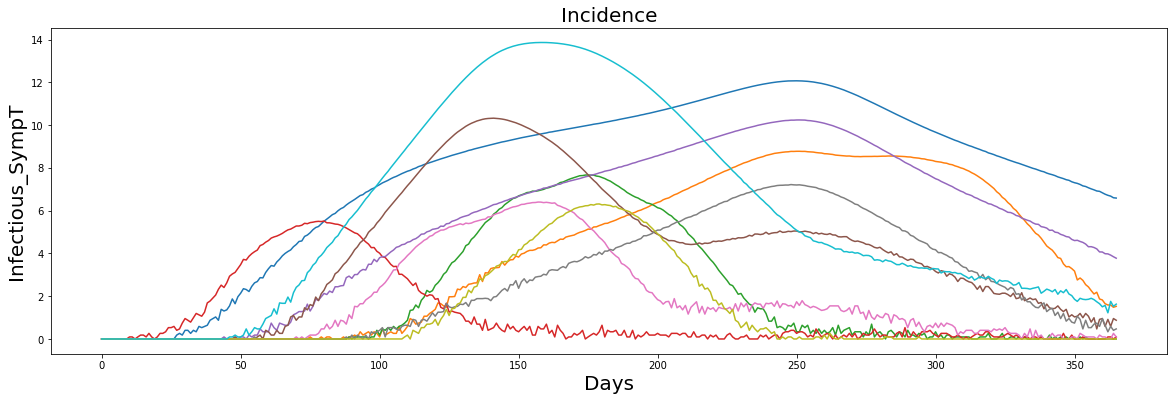

In [94]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.set_title("Incidence", fontsize=20)
ax.set_ylabel("Infectious_SympT", fontsize=20)
ax.set_xlabel("Days", fontsize=20)
for i in range(10):
    ax.plot(np.log1p(incidences_agg[10, i, :, 1]))

## Log transform the data because :D

In [111]:
# incidenes_agg_log = np.log1p(incidences_agg[..., [1, 2]])

# with h5py.File("data/EpiGCN/processing/incidences_log.hdf5", "w") as f:
#     f.create_dataset('incidences_log', data=incidenes_agg_log, compression='lzf')

In [3]:
with h5py.File("data/EpiGCN/processing/incidences_log.hdf5", "r") as f:
    incidenes_agg_log = f['incidences_log'].value

In [4]:
incidenes_agg_log.shape

(232, 232, 366, 2)

In [5]:
with gzip.open('data/output_0000.h5.gz') as fp:
    f = h5py.File(fp,'r')
    compartments = f['dset'].attrs['Columns']
    country_ids = f['dset'].attrs['SelectedCountries']

Since the countries are ordered according to `country_ids`, we reorder them so that they are now ordered correctly

In [6]:
def reset_country_order(incidences_agg_log):    
    incidences_agg_log_copy = np.zeros_like(incidences_agg_log, dtype=np.float)

    for ix, country_id in enumerate(country_ids):
        incidences_agg_log_copy[:, country_id, :, :] = incidences_agg_log[:, ix, :, :]
    return incidences_agg_log_copy

In [7]:
incidenes_agg_log = reset_country_order(incidenes_agg_log)

In [8]:
incidenes_agg_log.sum()

181141059.6178204

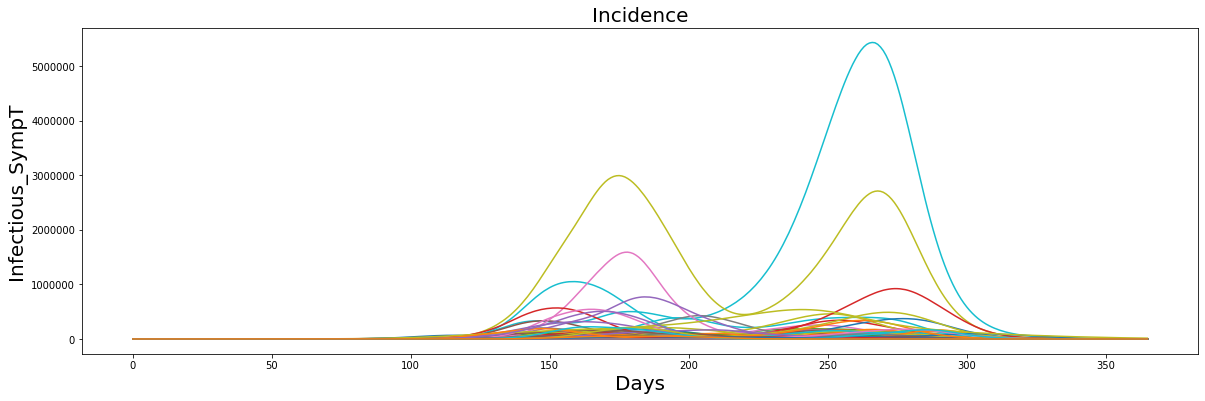

In [9]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.set_title("Incidence", fontsize=20)
ax.set_ylabel("Infectious_SympT", fontsize=20)
ax.set_xlabel("Days", fontsize=20)
for i in range(232):
    ax.plot(np.expm1(incidenes_agg_log[10, i, :, 1]))

## Sliding window

The implementation will essentially reverse the time series (since we have to back-forecast)

In [10]:
def generate_sliding_windows_dataset(incidences, t_lag=10, window_size=10):
    """
    :t_lag: 
    :window_size: assumes this is less than 366
    """
    x_data, y_data = [], []
    start, end = t_lag + window_size, 366
    window_indices = np.arange(start, end, step=1)
    for ix in tqdm.tqdm_notebook(list(reversed(window_indices))):
        x = incidences[:, :, (ix - window_size + 1) : (ix + 1), :]
        y = incidences[:, :, (ix - window_size - t_lag + 1), :]

        ## expand dims for y so that there is a single dimension for y
        ## and then swap last 2 axis so that counts are again the last axis
        y = np.swapaxes(np.expand_dims(y, -1), -1, -2)
        x_data.append(x)
        y_data.append(y)
    return np.stack(x_data), np.stack(y_data)

In [11]:
t_lag = 10
window_size = 10
x_ts, y_ts = generate_sliding_windows_dataset(incidenes_agg_log, t_lag, window_size)

# Plotting shifted TS

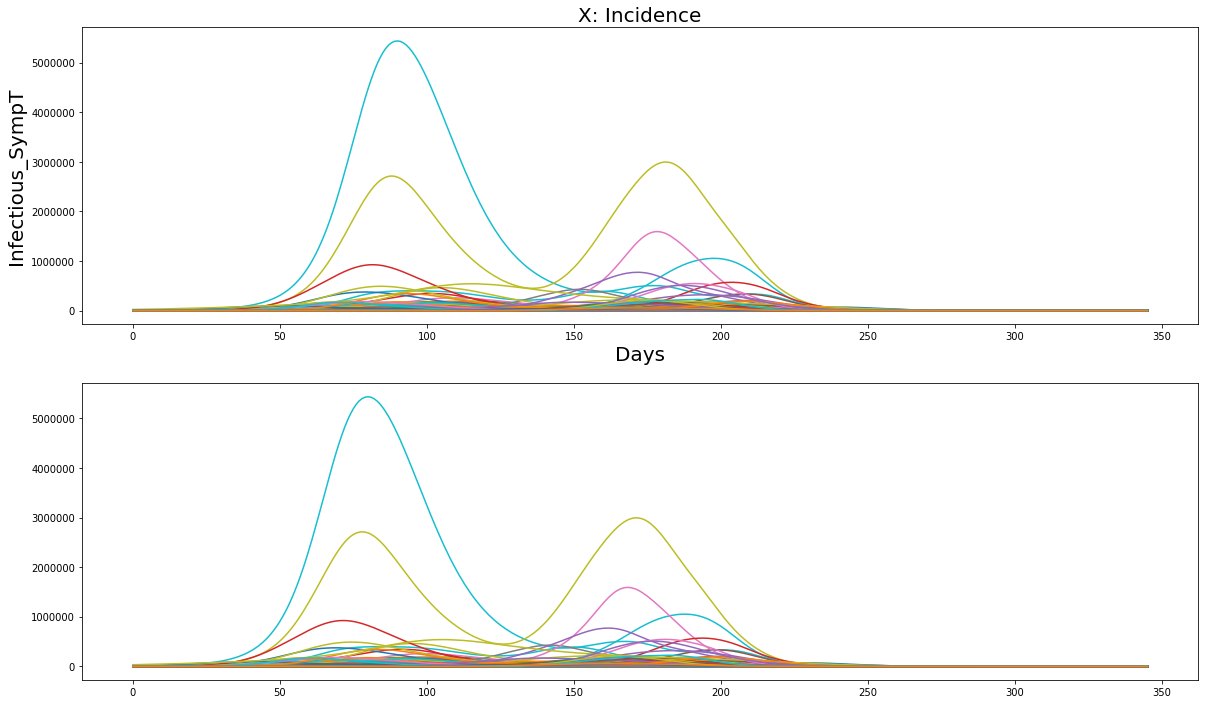

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))
ax[0].set_title("X: Incidence", fontsize=20)
ax[0].set_ylabel("Infectious_SympT", fontsize=20)
ax[0].set_xlabel("Days", fontsize=20)
for i in range(x_ts.shape[1]):
    ax[0].plot(np.expm1(x_ts[:, 10, i, 0, 0]))
    ax[1].plot(np.expm1(y_ts[:, 10, i, 0, 0]))

In [13]:
from sklearn.model_selection import train_test_split


def get_train_test_indices(test_ratio=0.1, random_seed=42):
    num_samples = 366 - t_lag - window_size
    train_indices, test_indices = train_test_split(
        range(num_samples),
        test_size=int(num_samples * test_ratio),
        random_state=random_seed,
        shuffle=False,
    )
    return train_indices, test_indices


train_indices, test_indices = get_train_test_indices()

In [14]:
x_train = x_ts[train_indices]
x_test = x_ts[test_indices]
y_train = y_ts[train_indices]
y_test = y_ts[test_indices]

In [15]:
print("X train shape: ", x_train.shape)
print("X test shape: ", x_test.shape)
print("Y train shape: ", y_train.shape)
print("Y test shape: ", y_test.shape)

X train shape:  (312, 232, 232, 10, 2)
X test shape:  (34, 232, 232, 10, 2)
Y train shape:  (312, 232, 232, 1, 2)
Y test shape:  (34, 232, 232, 1, 2)


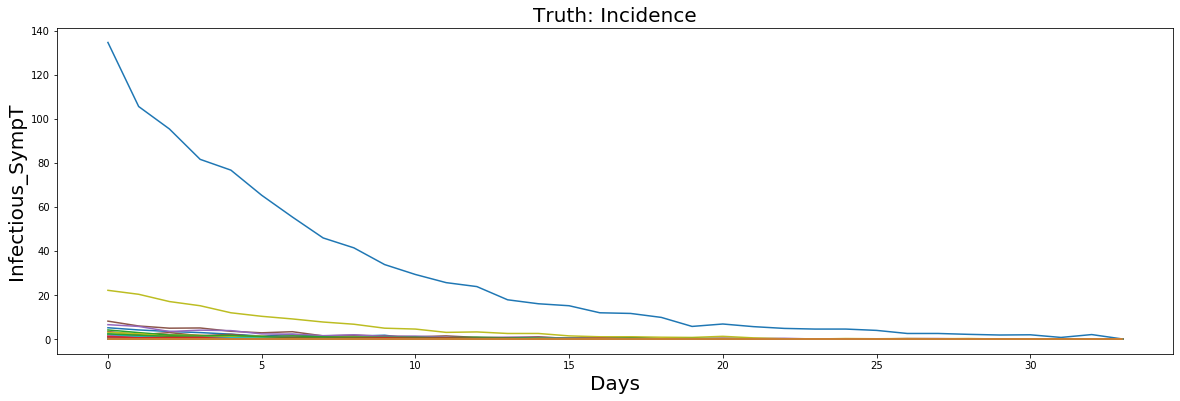

In [18]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.set_title("Truth: Incidence", fontsize=20)
ax.set_ylabel("Infectious_SympT", fontsize=20)
ax.set_xlabel("Days", fontsize=20)
for i in range(232):
    ax.plot(np.expm1(y_test[:, 10, i, 0, 0]))

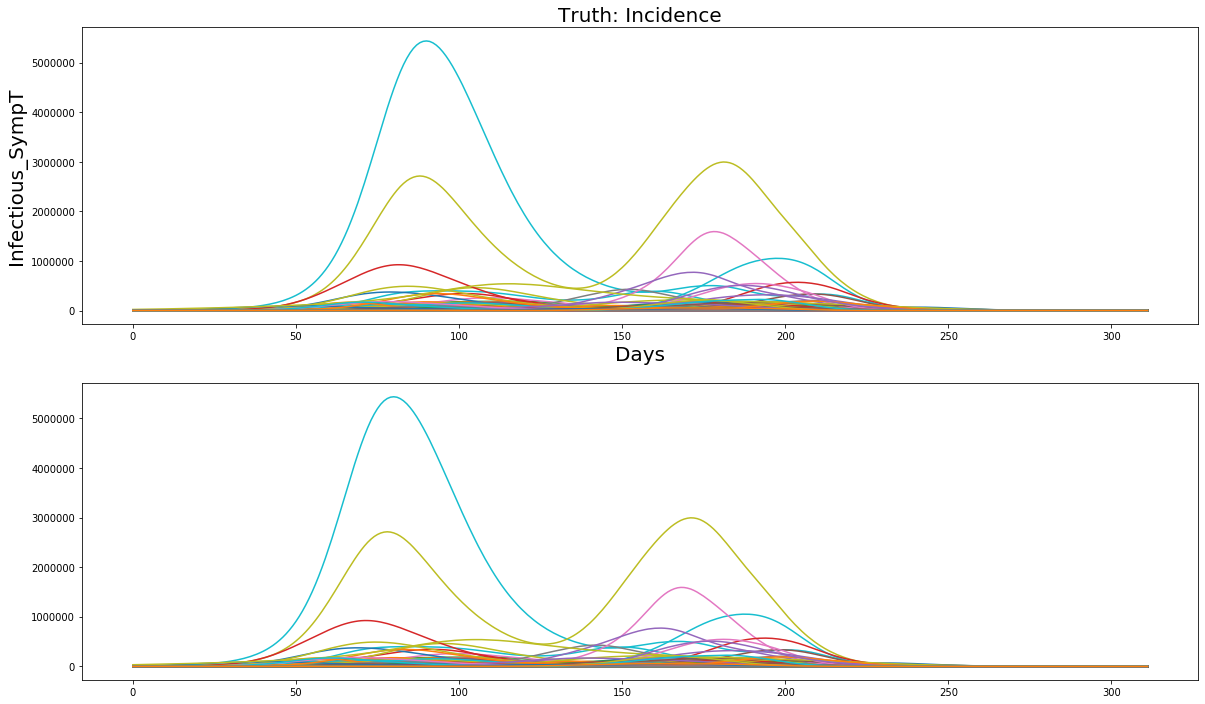

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))
ax[0].set_title("Truth: Incidence", fontsize=20)
ax[0].set_ylabel("Infectious_SympT", fontsize=20)
ax[0].set_xlabel("Days", fontsize=20)
for i in range(y_test.shape[1]):
    ax[0].plot(np.expm1(x_train[:, 10, i, 0, 0]))
    ax[1].plot(np.expm1(y_train[:, 10, i, 0, 0]))

## Standard Scale the based on train

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train.reshape(-1, 2)).reshape(-1, 232, 232, 10, 2)
x_test = scaler.transform(x_test.reshape(-1, 2)).reshape(-1, 232, 232, 10, 2)
y_train = scaler.transform(y_train.reshape(-1, 2)).reshape(-1, 232, 232, 1, 2)
y_test = scaler.transform(y_test.reshape(-1, 2)).reshape(-1, 232, 232, 1, 2)

In [21]:
print("X train shape: ", x_train.shape)
print("X test shape: ", x_test.shape)
print("Y train shape: ", y_train.shape)
print("Y test shape: ", y_test.shape)

X train shape:  (312, 232, 232, 10, 2)
X test shape:  (34, 232, 232, 10, 2)
Y train shape:  (312, 232, 232, 1, 2)
Y test shape:  (34, 232, 232, 1, 2)


In [22]:
import joblib
joblib.dump(scaler, "data/EpiGCN/standard_scaler.pkl")

['data/EpiGCN/standard_scaler.pkl']

## Serialize train test set with h5py

In [23]:
with h5py.File("data/EpiGCN/train_test.hdf5", "w") as f:
    f.create_dataset('x_train', data=x_train, compression='lzf')
    f.create_dataset('x_test', data=x_test, compression='lzf')
    f.create_dataset('y_train', data=y_train, compression='lzf')
    f.create_dataset('y_test', data=y_test, compression='lzf')

In [86]:
num_lstm_layers = 10
hidden_size = 1024

In [87]:
lstm = (4 * hidden_size * hidden_size) + (4 * hidden_size * 2) + (4 * hidden_size * 232*232)
lstm *= num_lstm_layers

In [88]:
linear = num_lstm_layers * hidden_size * 232 * 232

In [89]:
(linear * 4)/2**30

2.05322265625

In [90]:
(lstm * 4)/2**30

8.36944580078125

In [75]:
linear/lstm

0.24860510660311125